# Large Bubbles Error Detection

This file contains the algorithm to detect the large bubbles inside the cardboards

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import os

In [28]:
def undistort_image(image, mtx, dist):
    """
    Undistort the image using the camera matrix and distortion coefficients.
    """
    h, w = image.shape[:2]
    new_camera_mtx, roi = cv.getOptimalNewCameraMatrix(mtx, dist, (w, h), 1, (w, h))
    undistorted_img = cv.undistort(image, mtx, dist, None, new_camera_mtx)
    return undistorted_img

def cardboardMaskDraw(img, x_roi, y_roi, w_roi, h_roi):
    """
    Generates a binary mask of the largest contour within a specified ROI,
    corresponding to the cardboard's edge.

    This function applies preprocessing steps including Gaussian blur, Canny edge detection,
    dilation, and morphological closing to robustly detect the edges of the cardboard.
    It returns a filled mask of the largest detected contour, assumed to be the cardboard.

    Parameters
    ----------
    img : np.ndarray
        Input image (grayscale or single channel BGR component).
    x_roi : int
        X-coordinate of the top-left corner of the ROI.
    y_roi : int
        Y-coordinate of the top-left corner of the ROI.
    w_roi : int
        Width of the ROI.
    h_roi : int
        Height of the ROI.

    Returns
    -------
    cardboard_mask : np.ndarray
        Binary mask (uint8) with the largest contour filled in white (255),
        and background in black (0).
    """

    # Wa apply a gaussian blur to the image to reduce noise
    blur = cv.GaussianBlur(img, (5, 5), 0)

    # Start by extracting the ROI from the blurre image
    roi = blur[y_roi:y_roi+h_roi, x_roi:x_roi+w_roi]

    # We apply the Canny edge detection algorithm to the ROI
    canny_edges_roi = cv.Canny(roi, 40, 130, L2gradient=True)

    # We are going to dilate the edges to make them more pronounced
    kernel = np.ones((2, 2), np.uint8)
    canny_edges = cv.dilate(canny_edges_roi, kernel, iterations=1)

    # We had to add a morphological operation to close small gaps in the edges
    # Required to connect the small red pieces in the borders of the cardboard
    kernel_close = np.ones((5, 5), np.uint8)
    closed = cv.morphologyEx(canny_edges, cv.MORPH_CLOSE, kernel_close)

    # This final step is to assure that the edges are well defined and the 
    # cardboard contour is clearly visible
    dilated = cv.dilate(closed, np.ones((3, 3), np.uint8), iterations=1)

    # We find the contours in the image
    contours, _ = cv.findContours(dilated, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    # We take the largest contour based on area
    max_contour = max(contours, key=cv.contourArea)

    # We create the cardboard mask
    cardboard_mask = np.zeros_like(canny_edges, dtype=np.uint8)
    cv.drawContours(cardboard_mask, [max_contour], -1, 255, thickness=cv.FILLED)

    return cardboard_mask

def largeBubblesDetection(ambient_image, white_image, cardboard_mask):
    """
    Detects large bubbles or defects in a cardboard surface by analyzing contours
    under white and ambient lighting conditions. Combines contour detection and 
    filtering techniques to identify relevant defects.

    Parameters
    ----------
    ambient_image : np.ndarray
        Image captured under ambient lighting.
    white_image : np.ndarray
        Image captured under white light (e.g., from flash or top illumination).
    cardboard_mask : np.ndarray
        Binary mask indicating the area of the cardboard to analyze.

    Returns
    -------
    blur_ambient : np.ndarray
        Blurred version of the ambient light image (for debugging or visualization).
    blur_white : np.ndarray
        Blurred version of the white light image (for debugging or visualization).
    reference_contours : list
        Contours found in the ambient light image, representing printed regions.
    large_contours_candidates : list
        Initial list of defect contour candidates detected in white light.
    final_defects : list
        Filtered list of true defects after all proximity and geometry filters.
    """
    blur_white = cv.GaussianBlur(white_image, (5, 5), 0)
    blur_ambient = cv.GaussianBlur(ambient_image, (5, 5), 0)

    # Detect contours in the ambient image (reference: printed areas)
    edges_ambient = cv.Canny(blur_ambient, 50, 100)
    reference_contours, _ = cv.findContours(edges_ambient, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    print(f"{len(reference_contours)} printed contours are found.")

    # Detect defect candidates from the white light image
    large_contours_candidates = defectsCandidatesDetection(blur_white, cardboard_mask, light_source_position='top')

    # Filter those candidates based on proximity and shape
    final_defects = filterContours(white_image, cardboard_mask, reference_contours, large_contours_candidates)

    return blur_ambient, blur_white, reference_contours, large_contours_candidates, final_defects

def defectsCandidatesDetection(blur_white, cardboard_mask, light_source_position='top'):
    """
    Detects candidate defect contours using adaptive thresholding based on 
    the light source position and morphological edge detection.

    Parameters
    ----------
    blur_white : np.ndarray
        Blurred image captured under white light.
    cardboard_mask : np.ndarray
        Binary mask indicating the cardboard area.
    light_source_position : str, optional
        Direction of the light source. Must be one of ['top', 'bottom', 'left', 'right'].
        Default is 'top'.

    Returns
    -------
    large_contours_candidates : list
        List of contours that are potential defects (before filtering).
    """
    # Define thresholds based on light source orientation
    if light_source_position == 'top':
        th_1, th_2 = 80, 70
    elif light_source_position == 'bottom':
        th_1, th_2 = 70, 80
    elif light_source_position == 'left':
        th_1, th_2 = 80, 70
    elif light_source_position == 'right':
        th_1, th_2 = 70, 80
    else:
        raise ValueError("Invalid light source position.")

    # Split image and apply threshold dynamically
    h, w = blur_white.shape[:2]
    thTOZERO_full = np.zeros_like(blur_white)

    if light_source_position in ['top', 'bottom']:
        split_row = h * 2 // 3
        top_part = blur_white[:split_row, :]
        bottom_part = blur_white[split_row:, :]
        _, th_top = cv.threshold(top_part, th_1, 255, cv.THRESH_TOZERO)
        _, th_bottom = cv.threshold(bottom_part, th_2, 255, cv.THRESH_TOZERO)
        thTOZERO_full[:split_row, :] = th_top
        thTOZERO_full[split_row:, :] = th_bottom
    elif light_source_position in ['left', 'right']:
        split_col = w * 2 // 3
        left_part = blur_white[:, :split_col]
        right_part = blur_white[:, split_col:]
        _, th_left = cv.threshold(left_part, th_1, 255, cv.THRESH_TOZERO)
        _, th_right = cv.threshold(right_part, th_2, 255, cv.THRESH_TOZERO)
        thTOZERO_full[:, :split_col] = th_left
        thTOZERO_full[:, split_col:] = th_right

    # Apply mask and detect edges
    thTOZERO_masked = cv.bitwise_and(thTOZERO_full, thTOZERO_full, mask=cardboard_mask)
    edges_white = cv.Canny(thTOZERO_masked, 50, 150, apertureSize=3)

    # Combine with cardboard mask border
    border_kernel = np.ones((3, 3), np.uint8)
    mask_border = cv.morphologyEx(cardboard_mask, cv.MORPH_GRADIENT, border_kernel)
    combined_edges = cv.bitwise_or(edges_white, mask_border)

    # Morphological closing to improve contour continuity
    closing_kernel = np.ones((11, 11), np.uint8)
    closed_edges = cv.morphologyEx(combined_edges, cv.MORPH_CLOSE, closing_kernel)

    # Detect contours
    contours_candidates, _ = cv.findContours(closed_edges, cv.RETR_LIST, cv.CHAIN_APPROX_SIMPLE)

    # Filter based on minimum perimeter
    min_edge_length = 250
    large_contours_candidates = [cnt for cnt in contours_candidates if cv.arcLength(cnt, True) > min_edge_length]
    print(f"{len(large_contours_candidates)} candidates contours are detected.")

    return large_contours_candidates

def filterContours(white_image, cardboard_mask, reference_contours, large_contours_candidates):
    """
    Filters out false positives among defect candidates by checking their proximity to printed areas,
    their size, and whether they are nested within other contours.

    Parameters
    ----------
    white_image : np.ndarray
        Image captured under white light (used for shape/position info).
    cardboard_mask : np.ndarray
        Binary mask of the cardboard area.
    reference_contours : list
        Contours of the printed regions detected from ambient light.
    large_contours_candidates : list
        List of initial defect candidates to be filtered.

    Returns
    -------
    final_defects : list
        Filtered list of contours corresponding to real defects.
    """
    # Parameters for proximity filtering
    contact_distance_pixels = 5
    contact_threshold_percent = 0.50

    # Distance transform to check how close points are to printed areas
    reference_map = np.zeros(white_image.shape[:2], dtype='uint8')
    cv.drawContours(reference_map, reference_contours, -1, 255, 1)
    dist_transform = cv.distanceTransform(255 - reference_map, cv.DIST_L2, 3)

    true_defect_contours = []
    for candidate in large_contours_candidates:
        total_points = len(candidate)
        if total_points == 0:
            continue

        contact_points = sum(1 for pt in candidate if dist_transform[pt[0][1], pt[0][0]] <= contact_distance_pixels)
        if (contact_points / total_points) < contact_threshold_percent:
            true_defect_contours.append(candidate)

    print(f"After filtering based on the distance, {len(true_defect_contours)} defects are selected.")

    # Remove very large contours
    MAX_CONTOUR_LENGTH = 1500
    defects_after_length_filter = [cnt for cnt in true_defect_contours if cv.arcLength(cnt, True) < MAX_CONTOUR_LENGTH]
    print(f"After filtering based on the maximum length, {len(defects_after_length_filter)} are found.")

    # Remove nested contours
    final_defects = []
    for i, contour1 in enumerate(defects_after_length_filter):
        is_contained = False
        for j, contour2 in enumerate(defects_after_length_filter):
            if i != j and cv.contourArea(contour1) < cv.contourArea(contour2):
                test_point = (float(contour1[0][0][0]), float(contour1[0][0][1]))
                if cv.pointPolygonTest(contour2, test_point, False) > 0:
                    is_contained = True
                    break
        if not is_contained:
            final_defects.append(contour1)

    print(f"Finally {len(final_defects)} defects are found.")
    return final_defects


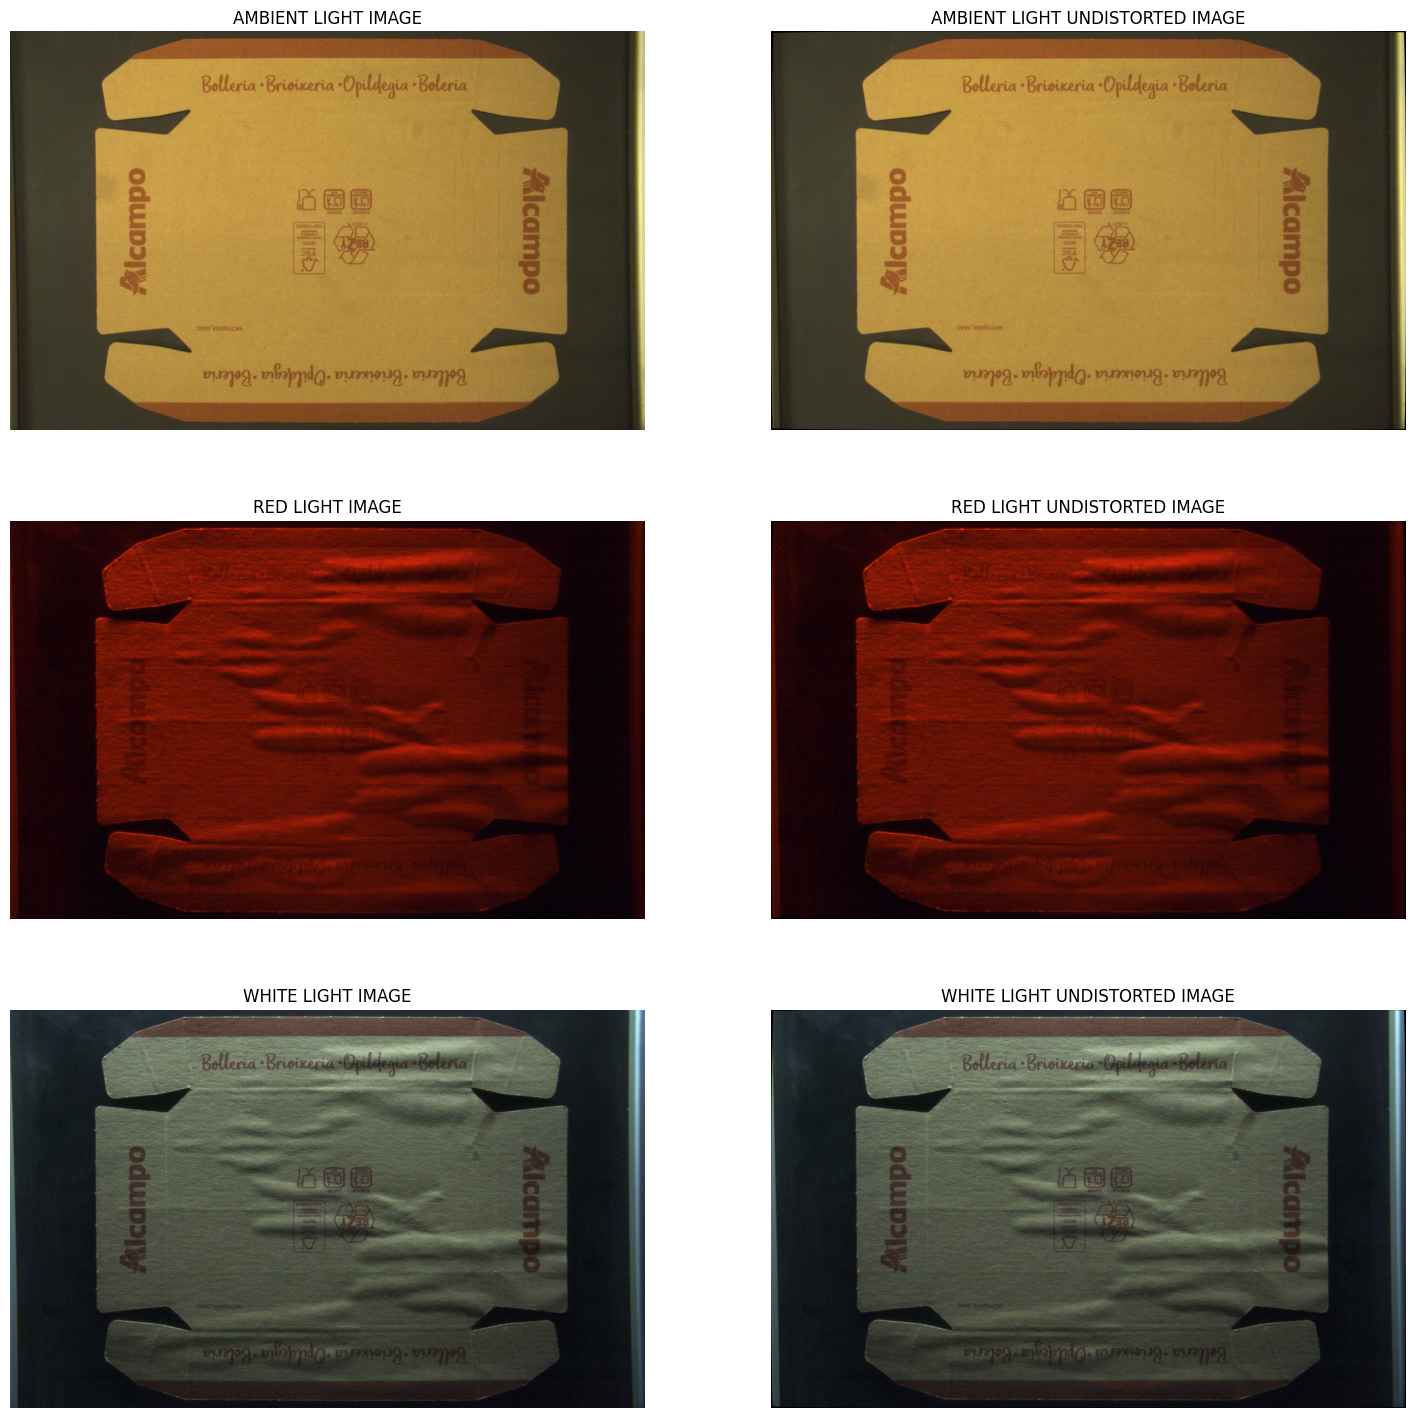

In [29]:
# Working directory
baseFolder = os.getcwd()

# image Number
imageNumber = 1

if imageNumber == 1:
    # Load the image with Ambient Light
    AL_img = cv.imread(os.path.join(baseFolder, 'FINAL_PHOTOS', 'BUBBLES_RETAKE', '1_ROOM_LIGHT.png'))

    # Load the image with the red Light
    RL_img = cv.imread(os.path.join(baseFolder, 'FINAL_PHOTOS', 'BUBBLES_RETAKE', '1_RED_LIGHT_2.png'))

    # Load the iage with the white Light
    WL_img = cv.imread(os.path.join(baseFolder, 'FINAL_PHOTOS', 'BUBBLES_RETAKE', '1_WHITE_LIGHT.png'))
else:
    # Load the image with Ambient Light
    AL_img = cv.imread(os.path.join(baseFolder, 'FINAL_PHOTOS', 'BUBBLES_RETAKE', '2_WHITE_LIGHT_2.png'))

    # Load the image with the red Light
    RL_img = cv.imread(os.path.join(baseFolder, 'FINAL_PHOTOS', 'BUBBLES_RETAKE', '2_RED_LIGHT_2.png'))

    # Load the iage with the white Light
    WL_img = cv.imread(os.path.join(baseFolder, 'FINAL_PHOTOS', 'BUBBLES_RETAKE', '2_WHITE_LIGHT_1.png'))

# Loading the camera parameters obtained from the calibration process
cameraParameters = np.load(baseFolder + "/calibration/camera_lens_12mm.npz")

# We extract the camera matrix and distortion coefficients, through the keys in the dictionary
mtx = cameraParameters['mtx']
dist = cameraParameters['dist']
res = cameraParameters['res']

# Undistort the images using the camera parameters
udst_AL_img = undistort_image(AL_img, mtx, dist)
udst_RL_img = undistort_image(RL_img, mtx, dist)
udst_WL_img = undistort_image(WL_img, mtx, dist)

plt.figure(figsize=(18, 18))

plt.subplot(3, 2, 1)
plt.imshow(cv.cvtColor(AL_img, cv.COLOR_BGR2RGB))
plt.axis("off")
plt.title("AMBIENT LIGHT IMAGE")
plt.subplot(3, 2, 2)
plt.imshow(cv.cvtColor(udst_AL_img, cv.COLOR_BGR2RGB))
plt.axis("off")
plt.title("AMBIENT LIGHT UNDISTORTED IMAGE")

plt.subplot(3, 2, 3)
plt.imshow(cv.cvtColor(RL_img, cv.COLOR_BGR2RGB))
plt.axis("off")
plt.title("RED LIGHT IMAGE")
plt.subplot(3, 2, 4)
plt.imshow(cv.cvtColor(udst_RL_img, cv.COLOR_BGR2RGB))
plt.axis("off")
plt.title("RED LIGHT UNDISTORTED IMAGE")

plt.subplot(3, 2, 5)
plt.imshow(cv.cvtColor(WL_img, cv.COLOR_BGR2RGB))
plt.axis("off")
plt.title("WHITE LIGHT IMAGE")
plt.subplot(3, 2, 6)
plt.imshow(cv.cvtColor(udst_WL_img, cv.COLOR_BGR2RGB))
plt.axis("off")
plt.title("WHITE LIGHT UNDISTORTED IMAGE")

plt.show()


## Region of Interest

We are going to focus on the ambient ligth image for finding the borders of the cardboard and use only this section of the image, for that reason we are going to start by doing an optimal threshold of the image, using OTSU

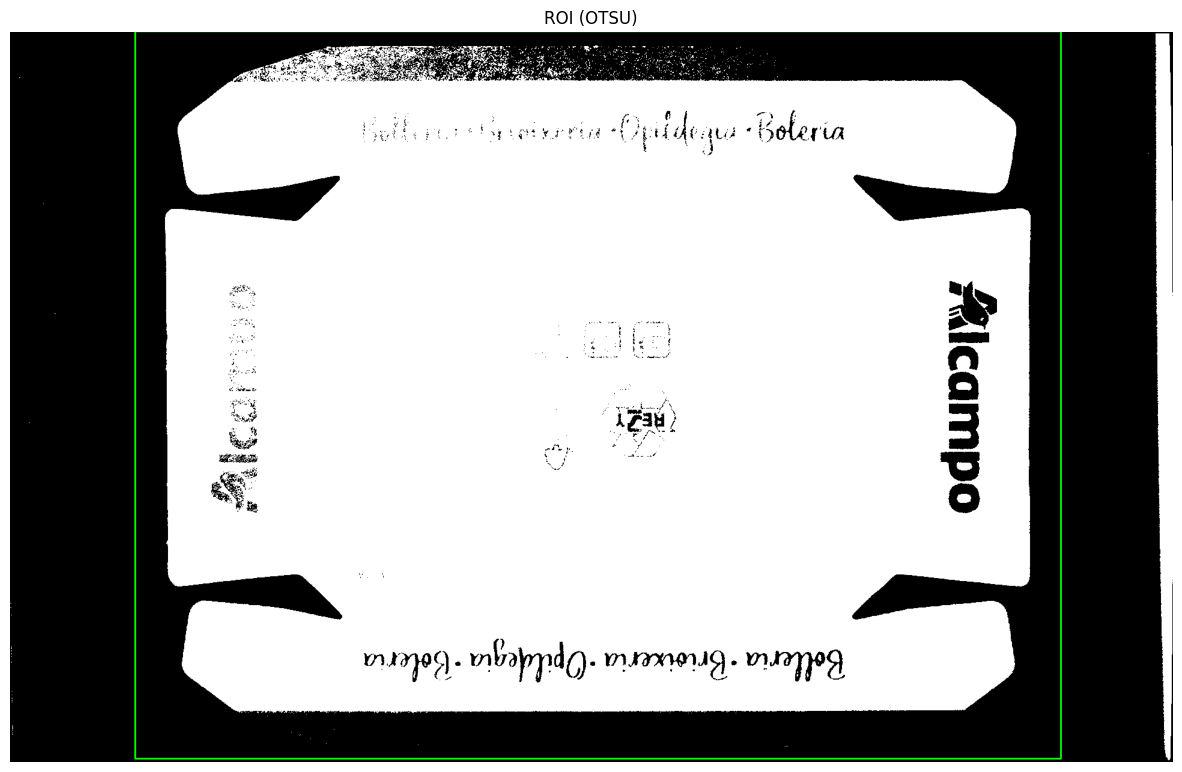

In [30]:
# Thresholding the imnage OTSU gives us the optimal threshold value
udst_AL_gray = cv.cvtColor(udst_AL_img, cv.COLOR_BGR2GRAY)
_ , th_Bin_OTSU = cv.threshold(udst_AL_gray, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)

# Find the contours in the image
contours, _ = cv.findContours(th_Bin_OTSU, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

# We search the biggest contour Area Based
contour_max = max(contours, key=cv.contourArea)

# Bounding box of the biggest contour
x, y, w, h = cv.boundingRect(contour_max)

# We expand the ROI
margin = 50  # Additional pixels to the ROI
x_roi = max(x - margin, 0)
y_roi = max(y - margin, 0)
w_roi = min(w + 2 * margin, th_Bin_OTSU.shape[1] - x_roi)
h_roi = min(h + 2 * margin, th_Bin_OTSU.shape[0] - y_roi)

# Draw a green rectangle using BGR
img_with_roi = cv.cvtColor(th_Bin_OTSU, cv.COLOR_GRAY2BGR)
cv.rectangle(img_with_roi, (x_roi, y_roi), (x_roi + w_roi, y_roi + h_roi), (0, 255, 0), 2)

# We show the image with the ROI detected
plt.figure(figsize=(15, 10))
plt.imshow(img_with_roi)
plt.title("ROI (OTSU)")
plt.axis("off")
plt.show()

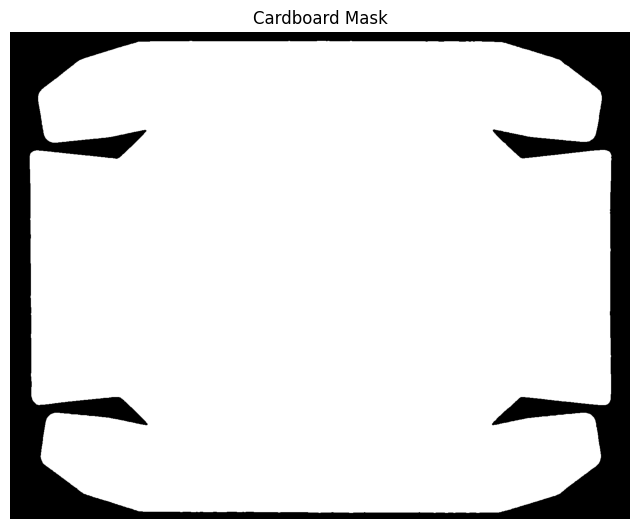

In [31]:
# We create the cardboard mask
cardboard_mask = cardboardMaskDraw(udst_AL_img, x_roi, y_roi, w_roi, h_roi)

# 9. Visualizar resultado
plt.figure(figsize=(8, 8))
plt.imshow(cardboard_mask, cmap='gray')
plt.title("Cardboard Mask")
plt.axis("off")
plt.show()

## Analysis based on the Ambient Light and White Light Images

Based on the found ROI and cardboard mask we are ready to work on the cardboard iluminated in tangential direction having the ambien light image as a reference

0 1210 208 1541


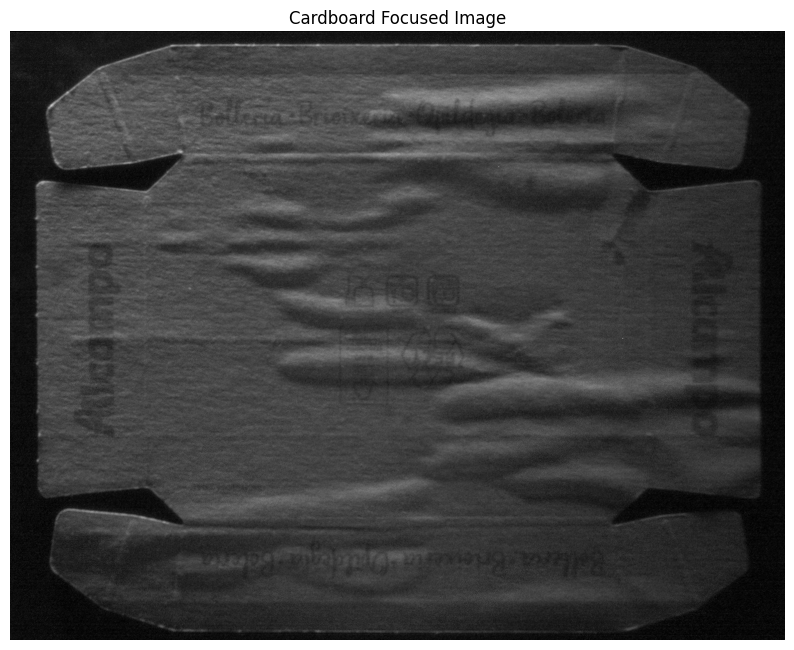

In [32]:
# For the analysis we need to convert the image to grayscale
udst_RL_gray = cv.cvtColor(udst_RL_img, cv.COLOR_BGR2GRAY)
udst_WL_gray = cv.cvtColor(udst_WL_img, cv.COLOR_BGR2GRAY)

print(y_roi, h_roi, x_roi, w_roi)

# Start by extracting the ROI from the Red Ligthed image
roi_RL_img = udst_RL_gray[y_roi:y_roi+h_roi, x_roi:x_roi+w_roi]
roi_AL_img = udst_AL_gray[y_roi:y_roi+h_roi, x_roi:x_roi+w_roi]
roi_WL_img = udst_WL_gray[y_roi:y_roi+h_roi, x_roi:x_roi+w_roi]

# We apply the mask to the red light image
cardboard_img = cv.bitwise_and(roi_RL_img, cardboard_mask)

# Mostrar el resultado
plt.figure(figsize=(10, 8))
plt.imshow(roi_RL_img, cmap='gray')
plt.title("Cardboard Focused Image")
plt.axis("off")
plt.show()

## Algorithm
The algorithm proposed is based on the difference between the image taken with the ambient light and the white light source tangentially to the cardboard

268 printed contours are found.
46 candidates contours are detected.
After filtering based on the distance, 35 defects are selected.
After filtering based on the maximum length, 31 are found.
Finally 29 defects are found.


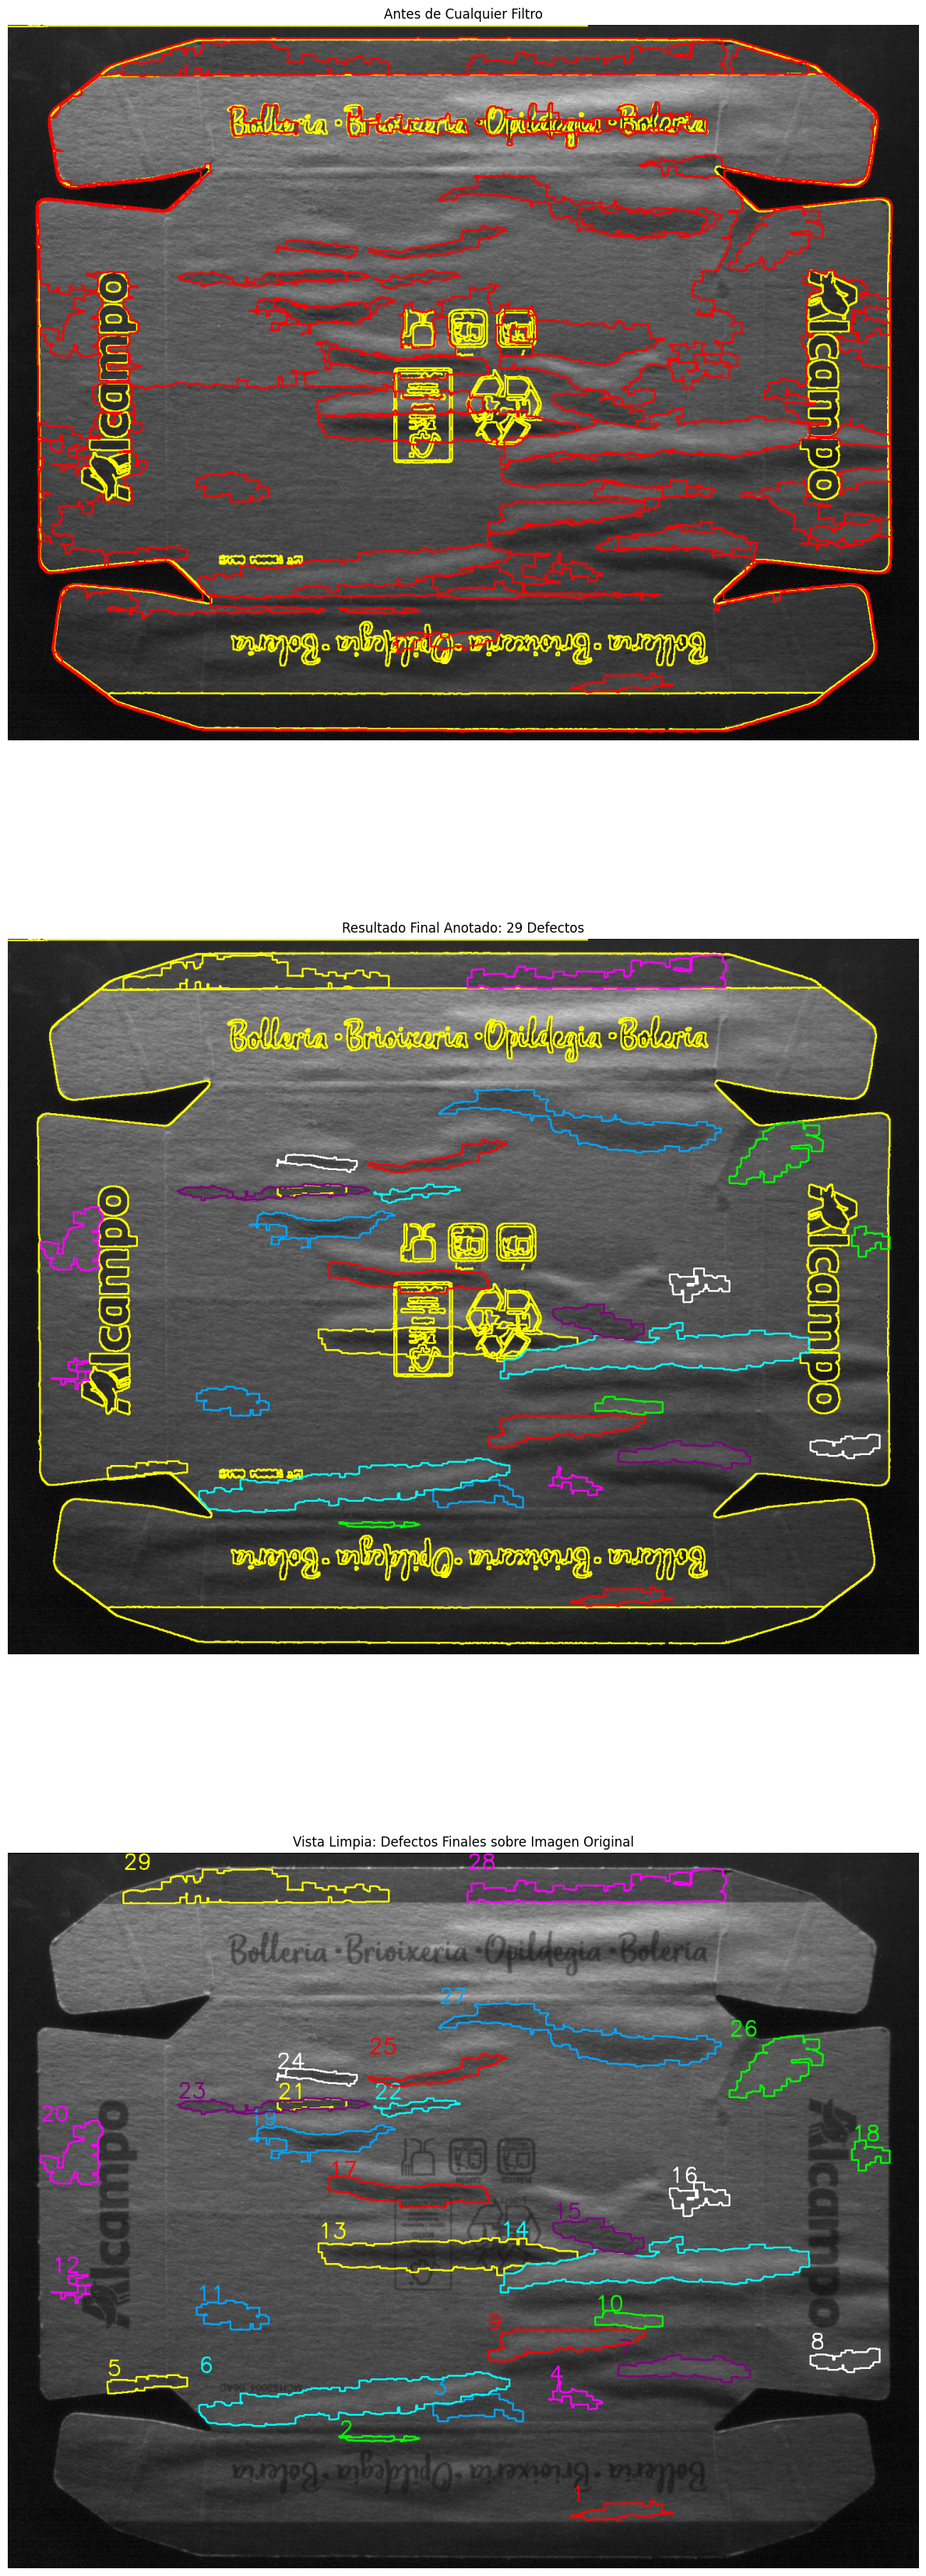

In [33]:
# Perform the large bubbles detection
blur_ambient, blur_white, reference_contours, large_contours_candidates, final_defects = largeBubblesDetection(roi_AL_img, roi_WL_img, cardboard_mask)

# Visualization
image_before_filter = cv.cvtColor(roi_WL_img, cv.COLOR_GRAY2BGR)
cv.drawContours(image_before_filter, reference_contours, -1, (0, 255, 255), 2)
cv.drawContours(image_before_filter, large_contours_candidates, -1, (0, 0, 255), 2)

image_after_filter = cv.cvtColor(roi_WL_img, cv.COLOR_GRAY2BGR)
cv.drawContours(image_after_filter, reference_contours, -1, (0, 255, 255), 2)

defects_on_image = cv.cvtColor(roi_WL_img, cv.COLOR_GRAY2BGR)

# Color List for drawing contours
colors = [
    (0, 0, 255), (0, 255, 0), (255, 165, 0), (255, 0, 255),
    (0, 255, 255), (255, 255, 0), (128, 0, 128), (255, 255, 255)
]

# Loop through the final defects and draw them on the images
for i, contour in enumerate(final_defects, start=1):
    color = colors[(i - 1) % len(colors)]
    cv.drawContours(image_after_filter, [contour], -1, color, 2)
    x, y, w, h = cv.boundingRect(contour)
    font = cv.FONT_HERSHEY_SIMPLEX
    cv.drawContours(defects_on_image, [contour], -1, color, 2)
    cv.putText(defects_on_image, str(i), (x, y), font, 1.2, color, 2)

# Mostrar las imágenes
plt.figure(figsize=(12, 36))

plt.subplot(3, 1, 1)
plt.imshow(cv.cvtColor(image_before_filter, cv.COLOR_BGR2RGB))
plt.title("Antes de Cualquier Filtro")
plt.axis("off")

plt.subplot(3, 1, 2)
plt.imshow(cv.cvtColor(image_after_filter, cv.COLOR_BGR2RGB))
plt.title(f"Resultado Final Anotado: {len(final_defects)} Defectos")
plt.axis("off")

plt.subplot(3, 1, 3)
plt.imshow(cv.cvtColor(defects_on_image, cv.COLOR_BGR2RGB))
plt.title("Vista Limpia: Defectos Finales sobre Imagen Original")
plt.axis("off")

plt.tight_layout()
plt.show()